## Predicting Loan Default
Python version: python3.11.

## Set up the Environment
### Import Needed Libraries and Functions

In [1]:
# Data Manipulation and Visualization Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Preprocessing, Model Selection, and Evaluation
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# Handling Imbalance and Metrics
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import accuracy_score

# Other
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

### Source the Data

In [2]:
# Load the data
data = pd.read_csv('./dataset.csv')

## Data Wrangling
Check if there are any missing or duplicate values.

In [3]:
# Check the data structure
data.info()
#data.head()
#data['Accounts Delinquent'].unique()

# Check if there are any missing values
# data.isnull().sum()

# Check for duplicate rows
# data[data.duplicated()]

# Check the variables and ranges
#data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Home Ownership                67463 non-null  object 
 10  Employment Duration           67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

### Numeric Values Enforced

In [4]:
# List of columns to be enforced as numeric
columns_to_convert = [
    "Loan Amount",
    "Funded Amount",
    "Funded Amount Investor",
    "Interest Rate",
    "Employment Duration",
    "Debt to Income",
    "Revolving Balance",
    "Revolving Utilities",
    "Total Received Interest",
    "Total Received Late Fee",
    "Recoveries",
    "Collection Recovery Fee",
    "Total Collection Amount",
    "Total Current Balance",
    "Total Revolving Credit Limit",
    "Delinquency - two years",
    "Inquires - six months",
    "Open Account",
    "Total Accounts",
    "Public Record",
    "Collection 12 months Medical",
    "Last week Pay"
]

# Convert each column in the list to numeric
for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

### Object Variables Enforced

In [5]:
# As object
data[['Term','Inquires - six months','Public Record',
      'Collection 12 months Medical']] = data[['Term','Inquires - six months','Public Record',
                                               'Collection 12 months Medical']].astype('object')

### Valuable Predictors

Variables that likely are valuable:

Variables that won't be counted as predictors (assumption, many categories):
1. ID (left for reference when splitting the data); 
2. Batch Enrolled; 
3. Payment plan - 1 value only; 
4. Accounts Delinquent - 1 value only.

### Cardinality of Categorical Features 

In [6]:
# Identify columns with categorical data (dtype 'object')
categorical_columns = data.select_dtypes(include='object').columns

# Use a list comprehension to get feature names and their cardinalities
cardinality_list = [{'Feature': feature, 'Cardinality': data[feature].nunique()}
                    for feature in categorical_columns]

# Convert the list to a DataFrame
cardinality_df = pd.DataFrame(cardinality_list)

# Sort the DataFrame based on the cardinality in descending order
cardinality_df = cardinality_df.sort_values(by='Cardinality', ascending=False)

# Display the DataFrame with a background gradient for better visualization
display = cardinality_df.style.background_gradient(cmap='viridis')
display


,Feature,Cardinality
7,Loan Title,109
1,Batch Enrolled,41
3,Sub Grade,35
2,Grade,7
8,Inquires - six months,6
9,Public Record,5
0,Term,3
4,Home Ownership,3
5,Verification Status,3
10,Initial List Status,2


In [7]:
# Variables that shouldn't be counted as predictors (assumption here for Batch Enrolled).
#   Remove from the dataset.
data = data.drop(['Accounts Delinquent', 'Payment Plan', 'ID', 
                  'Batch Enrolled'], axis=1) #'Loan Title',

### Loan Title Adjustments before Encoding

In [8]:
data['Loan Title'].value_counts().sort_values(ascending=False)

Credit card refinancing    30728
Debt consolidation         24841
Debt Consolidation          3544
Other                       2455
Home improvement            2211
                           ...  
Home loan                      6
Personal loan                  5
Getting Ahead                  5
Credit                         4
bills                          4
Name: Loan Title, Length: 109, dtype: int64

In [9]:
# Consolidate variations of 'Debt Consolidation' into one common label
consolidation_labels = ['Debt consolidation', 'Debt Sonsolidation', 'Debt Consolidation Loan', 'Consolidation', 
                        'Consolidate', 'Consolidated', 'Consolidation Loan','Consolidation', 'Consolidate', 'Consolidated',
                        'Consolidation Loan', 'debt', 'debt consolidation', 'debt loan','debt consolidation loan',
                        'consolidation','DEBT CONSOLIDATION','consolidate','Card Consolidation','Cards', 
                        'credit card consolidation','credit card', 'consolidation loan','Bill consolidation',
                        'CC Consolidation','CC Refi','CC-Refinance', 'get out of debt','CONSOLIDATE','pay off bills', 
                        'Debt Consolidation 2013','Refinance','Dept consolidation', 'Debt Payoff', 'Pay Off', 
                        'Debt Loan','CONSOLIDATION','Debt', 'cards', 'CC Refinance', 'CC consolidation', 'payoff',
                        'Bill Consolidation', 'credit card refinance', 'Debt Free', 'conso', 'Loan Consolidation', 
                        'Debt payoff','CC Loan', 'credit pay off', 'Payoff', 'My Loan', 'Loan', 'Bill Payoff',
                        'Debt Reduction','CC','bills', 'Refinance Loan','Get Debt Free','MYLOAN','Freedom',
                        'refi','relief','Credit card refinancing'] 
data['Loan Title'].replace(consolidation_labels, 'Debt Consolidation', inplace=True)

# Consolidate variations of 'Home Loan' into one common label
home_labels = ['Home improvement', 'Home Improvement', 'Home buying', 'Home', 'Home Improvement Loan', 'Home loan',
               'home improvement', 'House', 'Bathroom', 'Pool']
data['Loan Title'].replace(home_labels, 'Home Loan', inplace=True)

# Consolidate variations of 'Credit Loan' into one common label
credit_labels = ['Credit card refinancing', 'Credit Consolidation', 'Credit Cards',
          'Credit card payoff', 'Credit Card Consolidation',
          'Credit Card Refi', 'Credit Card Loan', 'Credit Card Debt',
          'Credit Card', 'Credit Card Refinance', 'Credit Loan',
          'Credit Card consolidation', 'Credit Card Paydown',
          'Credit card pay off', 'Credit card refinance', 'Credit',
          'Credit Card Payoff', 'Credit payoff',
          'Credit Card Refinance Loan','CC','credit card refinancing']
data['Loan Title'].replace(credit_labels, 'Credit Loan', inplace=True)

# Consolidate other categories
data['Loan Title'].replace(['Wedding Loan', 'Getting Ahead'], 'Other', inplace=True)

# Consolidate variations of 'Auto Loan' into one common label
auto_labels = ['Car financing', 'Car Loan']
data['Loan Title'].replace(auto_labels, 'Auto Loan', inplace=True)

# Consolidate variations of 'Personal Loan' into one common label
personal_labels = ['Personal loan', 'Personal', 'personal']
data['Loan Title'].replace(personal_labels, 'Personal Loan', inplace=True)

# Consolidate variations of 'Medical Loan' into one common label
medical_labels = ['Medical expenses', 'Medical', 'Medical loan']
data['Loan Title'].replace(medical_labels, 'Medical Loan', inplace=True)

# Replace individual labels with their respective consolidated label
data['Loan Title'].replace(['Credit Loan', 'vacation', 'loan1', 'Loan 1', 'Lending loan'], 
                          ['Debt Consolidation', 'Vacation', 'Other', 'Other', 'Lending Club'], inplace=True)

In [10]:
data['Loan Title'].value_counts().sort_values(ascending=False)

Debt Consolidation       60919
Other                     2500
Home Loan                 2467
Major purchase             487
Medical Loan               258
Business                   183
Moving and relocation      157
Auto Loan                  144
Personal Loan              134
Vacation                   124
Green loan                  45
Lending Club                45
Name: Loan Title, dtype: int64

## Exploratory Data Analysis

### Visualise All Distributions

In [11]:
# Separate numeric from object variables
cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()

Multiple clusters in the loan amount and the funded amount.

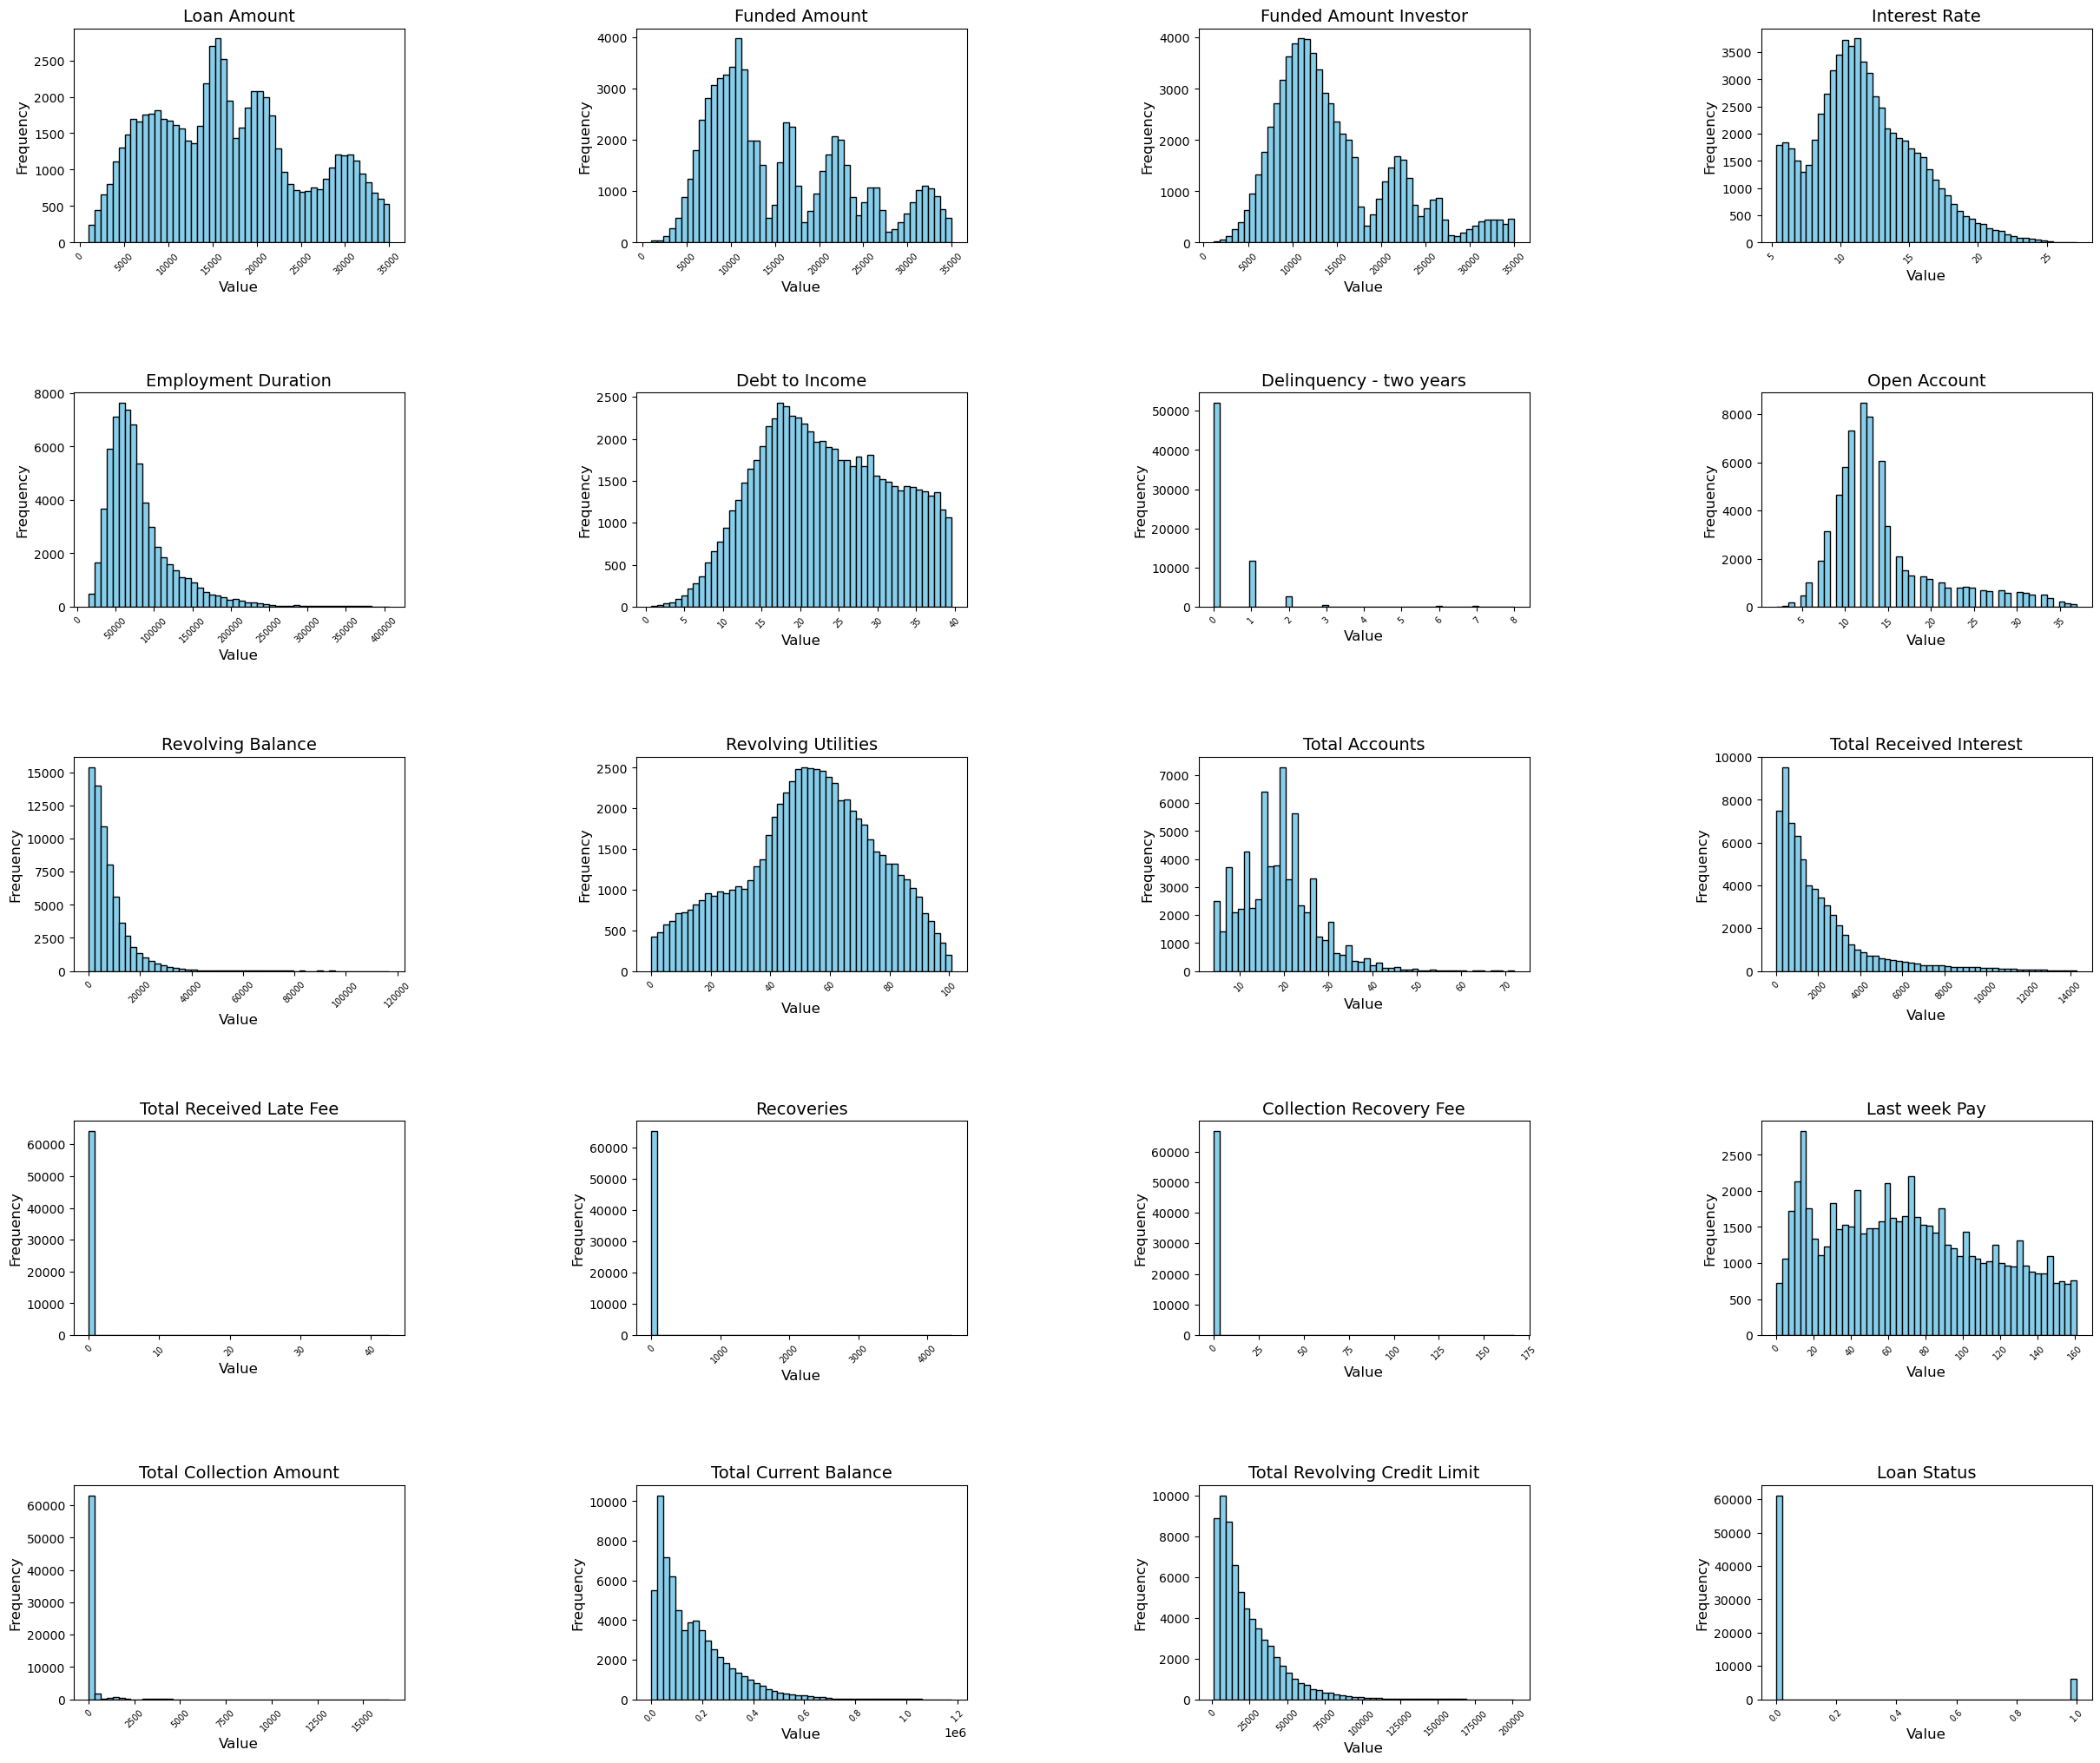

In [12]:
# Plotting histograms with an even larger figure size
axarr = data[num_features].hist(figsize=(30, 25), color='skyblue', edgecolor='black', bins=50)

# Beautifying each histogram
for ax in axarr.flatten():
    ax.grid(False)
    ax.set_title(ax.get_title(), fontsize=14)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=7)  # Rotate x-axis labels and adjust font size
    ax.tick_params(axis='y', labelsize=10)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.7)

plt.show()

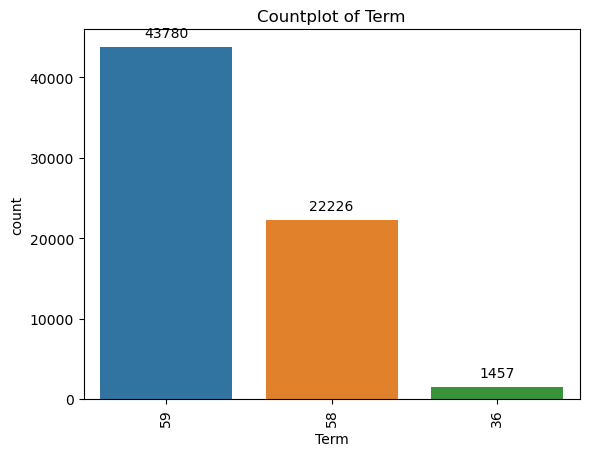

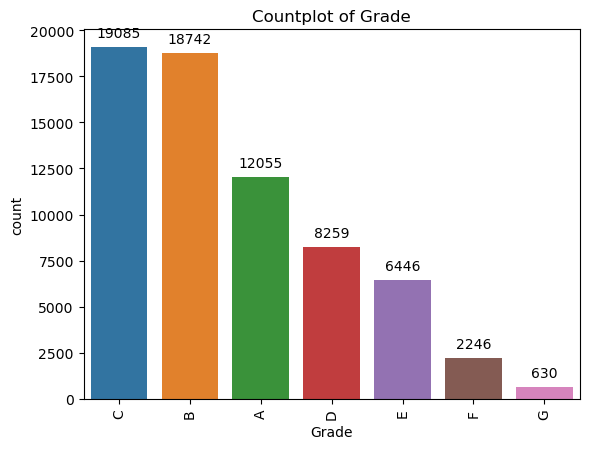

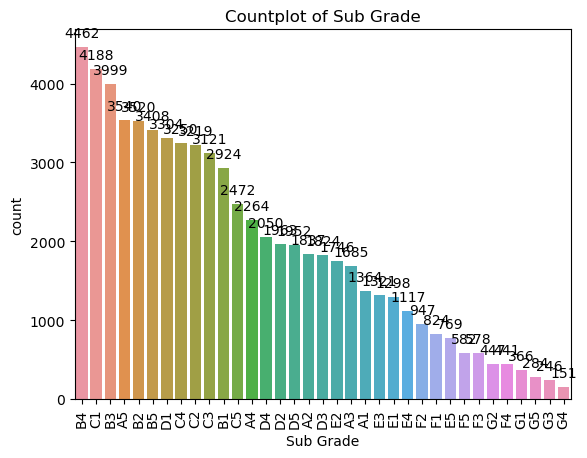

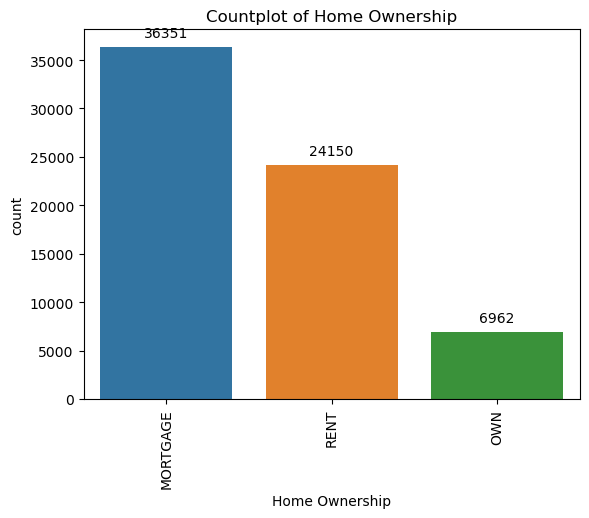

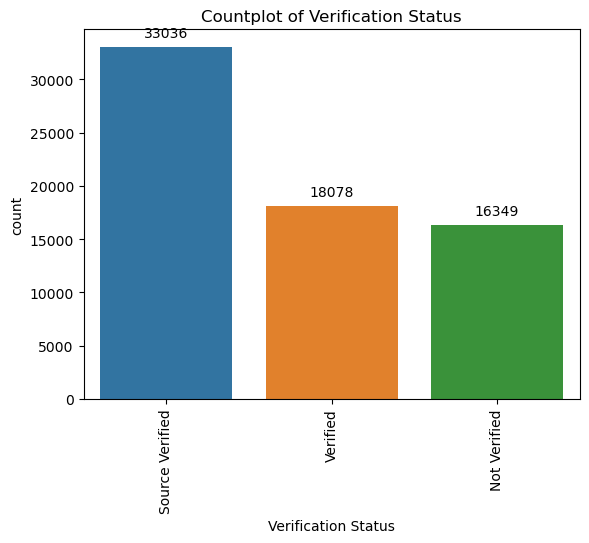

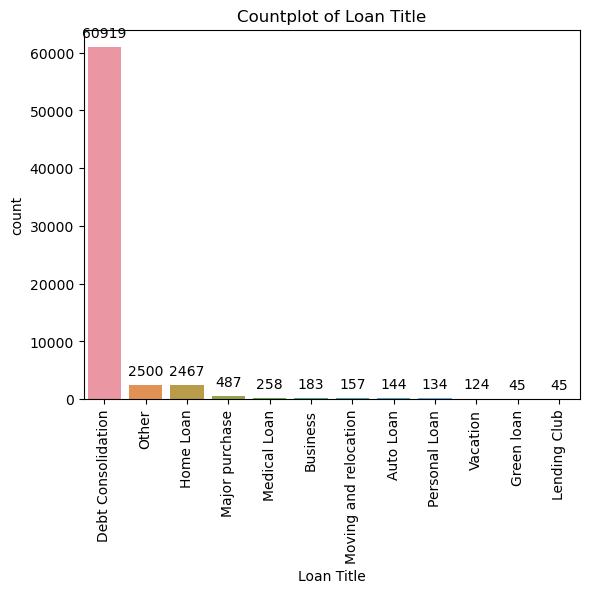

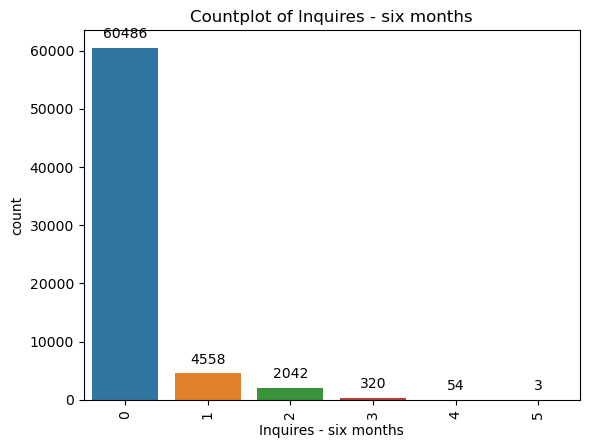

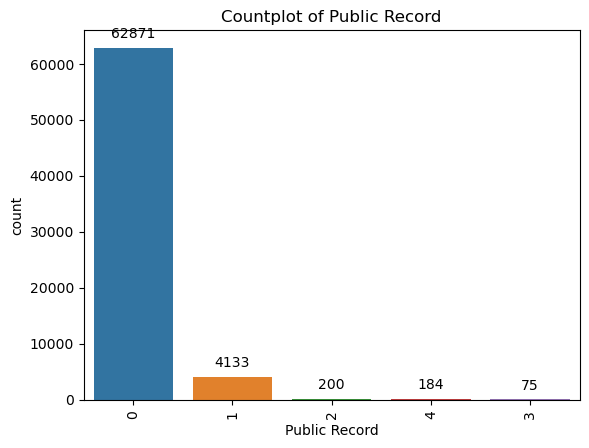

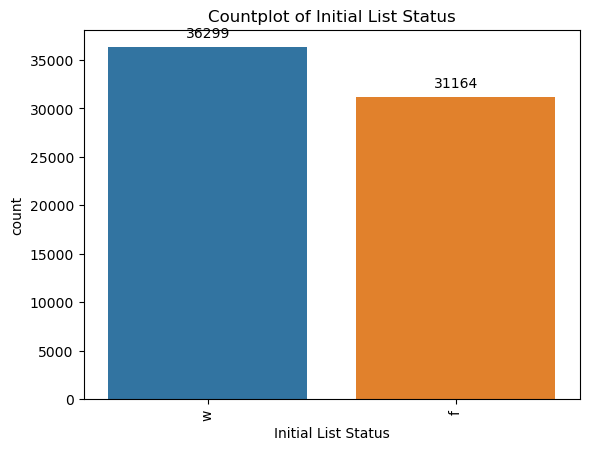

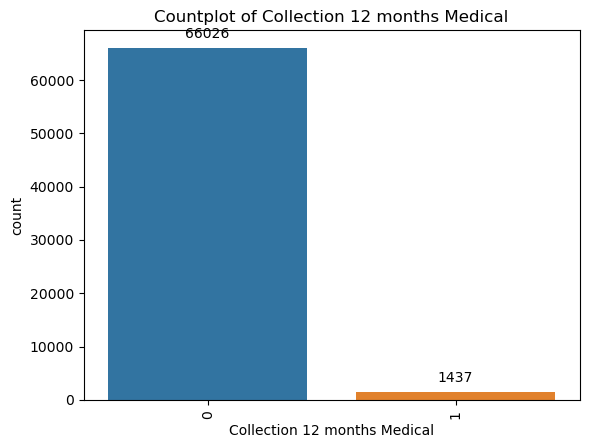

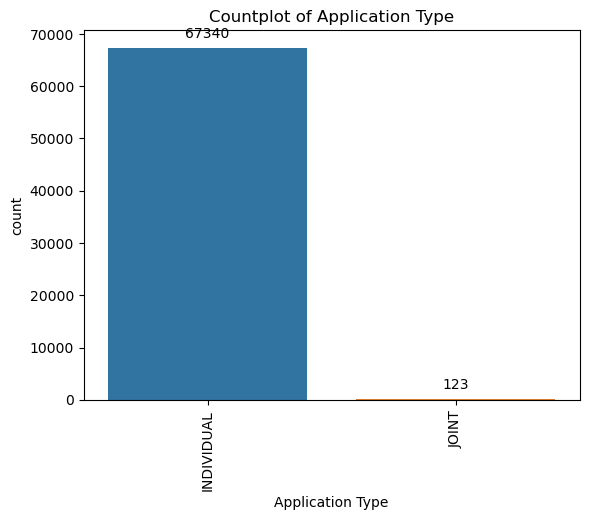

In [13]:
for feature in cat_features:
    # Create a count plot for the categorical feature
    ax = sns.countplot(x=feature, data=data, order=data[feature].value_counts().index)
    
    # Title for the plot
    plt.title(f'Countplot of {feature}')
    
    # Annotate each bar with its count value
    for p, label in zip(ax.patches, data[feature].value_counts()):
        ax.annotate(label, 
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the label
                    ha='center', va='center',  # Horizontally and vertically aligned to the center
                    xytext=(0,10),  # Offset the label position by 10 units above the bar
                    textcoords='offset points')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation='vertical')
    
    # Display the plot
    plt.show()


### Rename the "Loan Status" to "y"

In [14]:
# Rename Loan Status to y
data.rename(columns={'Loan Status': 'y'}, inplace=True)
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features_X = num_features.copy()
num_features_X.remove('y')

### Correlation Matrix

Correlation matrix reveals that there is little linear correlation between the predictors and the target variable.

y                               1.000000
Delinquency - two years         0.009990
Total Current Balance           0.009828
Total Received Late Fee         0.009365
Total Collection Amount         0.007892
Open Account                    0.007073
Last week Pay                   0.006117
Loan Amount                     0.004473
Revolving Utilities             0.004120
Collection Recovery Fee         0.003828
Employment Duration             0.003716
Debt to Income                  0.003057
Interest Rate                   0.002900
Total Received Interest         0.001680
Total Revolving Credit Limit    0.001454
Funded Amount                   0.001364
Revolving Balance               0.001073
Recoveries                      0.000652
Total Accounts                  0.000222
Funded Amount Investor          0.000091
Name: y, dtype: float64


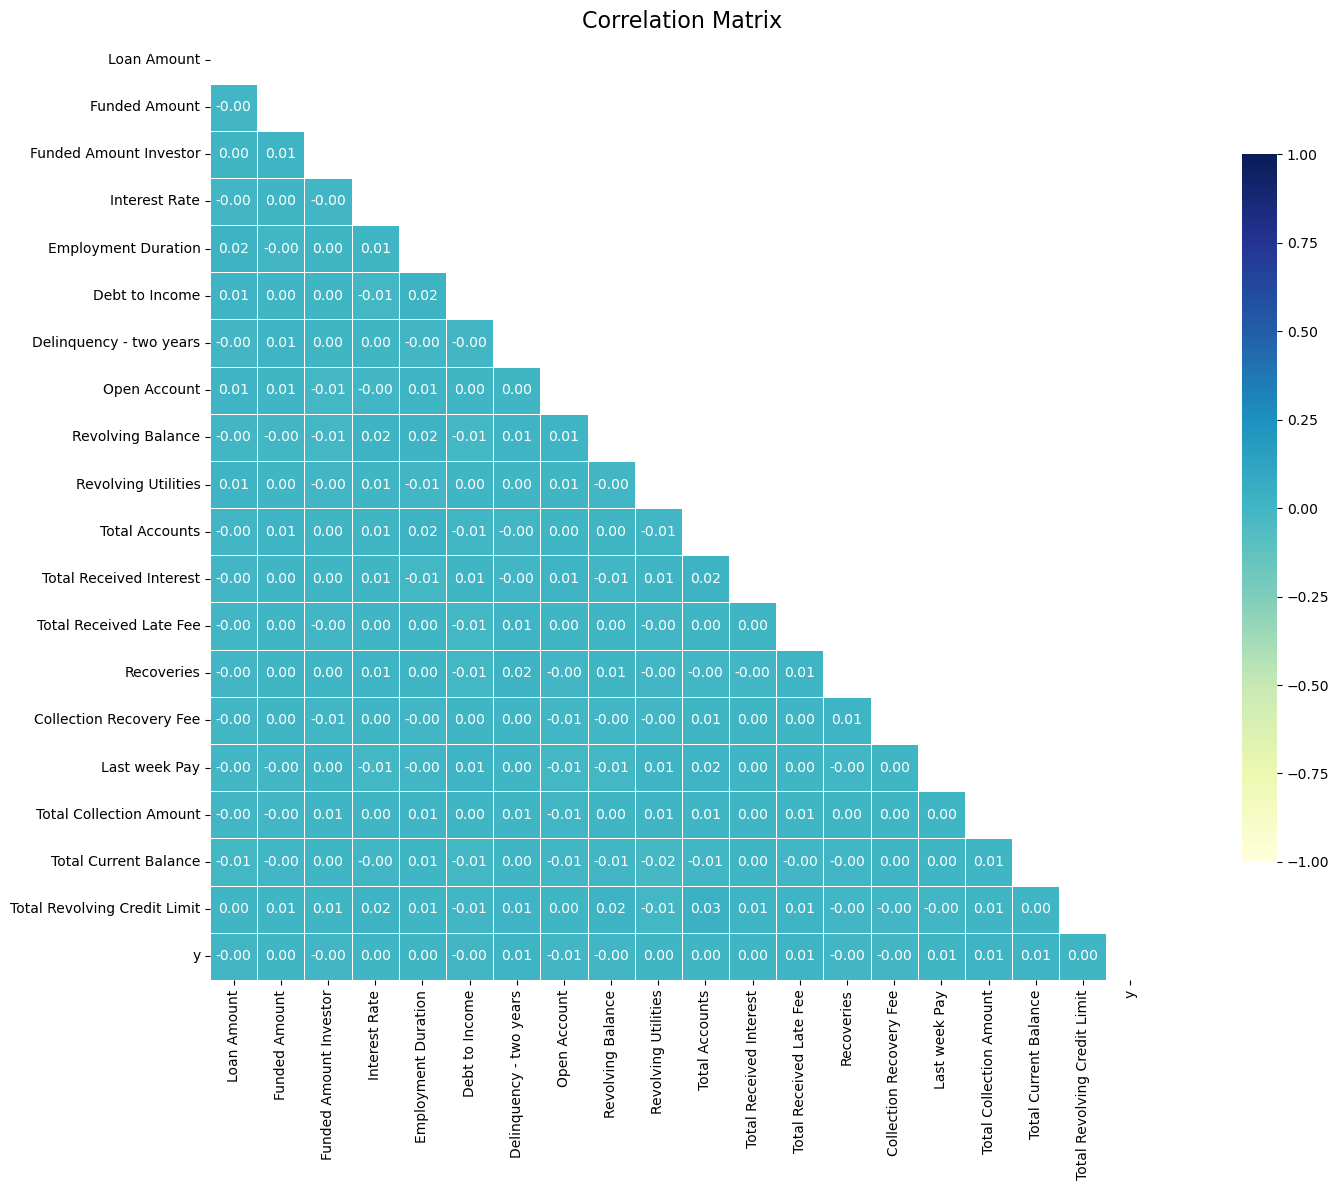

In [15]:
# Correlation matrix
corr_matrix = data[num_features].corr()

# Select the target variable 
target_corr = corr_matrix['y']

# Sort the correlations, descending
sorted_correlations = target_corr.abs().sort_values(ascending=False)

# Print the correlated features
print(sorted_correlations)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure with a larger size
plt.figure(figsize=(18, 12))

# Draw the heatmap with the mask, adjusted font size for annotations, and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='YlGnBu', vmax=1, vmin=-1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.75}, annot=True, fmt=".2f", annot_kws={"size": 10})

# Plot the correlation matrix
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

### Data Balance

The dataset is heavily imbalanced. Ways to deal with an imbalanced data set: nothing and evaluating the model with the correct performance metric, in this case, it could be Precision; SMOTE (Synthetic Minority Oversampling TEchnique), under-sampling, over-sampling, ADASYN.

0    61222
1     6241
Name: y, dtype: int64


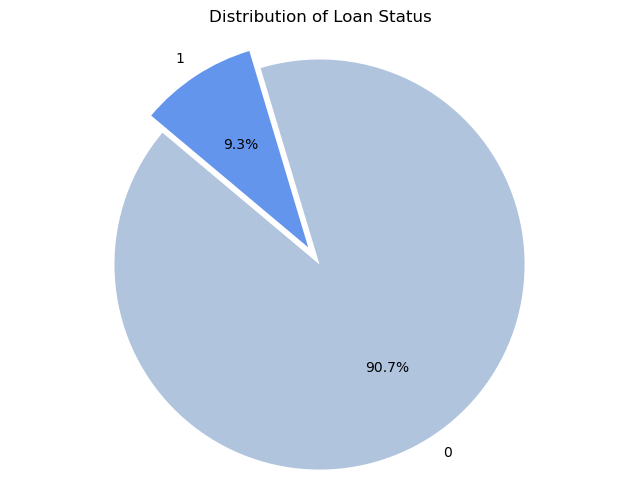

In [16]:
# Get the counts of each unique value in the 'Loan Status' column
loan_status_counts = data['y'].value_counts()
print(loan_status_counts)

# Plotting
colors = ['lightsteelblue', 'cornflowerblue']
# Explode the 1st slice for emphasis
explode = (0.1, 0)

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(loan_status_counts, labels=loan_status_counts.index, colors=colors,
        autopct='%1.1f%%', startangle=140, explode=explode)

plt.title('Distribution of Loan Status')
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()

### Check for Multicollinearity

Although there is multi-collinearity, it would be incorrect to drop such important variables. To alleviate this issue, Robust Scaling will be applied.

In [17]:
# Drop target
data_X = data.drop('y', axis=1)

# Check for multi-collinearity
def calculate_vif(data_X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = data_X.columns
    vif["VIF"] = [variance_inflation_factor(data_X.values, i) for i in range(data_X.shape[1])]

    return(vif.sort_values(by='VIF', ascending=False))

filtered_columns = [col for col in data_X.columns if col in num_features]
calculate_vif(data_X[filtered_columns])

,variables,VIF
3,Interest Rate,9.164345
5,Debt to Income,7.454378
9,Revolving Utilities,5.896808
7,Open Account,5.692280
10,Total Accounts,5.546943
2,Funded Amount Investor,5.185788
0,Loan Amount,4.719890
1,Funded Amount,4.452873
4,Employment Duration,4.013785
15,Last week Pay,3.522675


### Outlier Detection and Visualisation
1. Detecting Outliers using the IQR Method:
    a.For a given column, we calculate the Interquartile Range (IQR) which is the difference between the third quartile (Q3) and the first quartile (Q1).
    b. Define bounds for the outliers as:
        Lower Bound = Q1 - 1.5 * IQR
        Upper Bound = Q3 + 1.5 * IQR
    c. Any data point outside these bounds is considered an outlier.
2. Visualising the Data Distributions with Boxplots:
Boxplots provide a graphical representation of the central tendency and variability of the data, while also highlighting potential outliers.

In [18]:
# Define the function to detect outliers
def detect_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

# Outliers apply function
outliers = detect_outliers_iqr(data, 'Employment Duration')
print(outliers)

       Loan Amount  Funded Amount  Funded Amount Investor Term  Interest Rate  \
0            10000          32236             12329.36286   59      11.135007   
18            6373          12341             10452.66161   59       7.031039   
20           19696          27563             10526.63644   58      16.119184   
26           15709          10343             15668.20508   59      12.270097   
38           34866          11591             26043.49702   58      13.511902   
...            ...            ...                     ...  ...            ...   
67417         9315          15432             20434.94170   36      14.009766   
67421        16414          21259             16118.85784   58      10.728703   
67438         3443          31515             30719.69248   58       7.048846   
67445        12597          10573             25849.54390   59      15.255265   
67448         9047          23342             21202.86697   59       9.094515   

      Grade Sub Grade Home 

In [19]:
def count_outliers(data):
    outlier_counts = {}  # Create a dictionary to store the count of outliers for each column

    # Loop through only numeric columns in the DataFrame
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        # Use the detect_outliers_iqr function to get the outliers
        outliers = detect_outliers_iqr(data, column)
        
        # Store the count of outliers in the outlier_counts dictionary
        outlier_counts[column] = outliers.shape[0]

    return outlier_counts

# Get the count of outliers for each column
outlier_counts = count_outliers(data[num_features_X])

# Print the results
for column, count in outlier_counts.items():
    print(f"{column}: {count} outliers")


Loan Amount: 0 outliers
Funded Amount: 0 outliers
Funded Amount Investor: 3103 outliers
Interest Rate: 851 outliers
Employment Duration: 4115 outliers
Debt to Income: 0 outliers
Delinquency - two years: 15409 outliers
Open Account: 5614 outliers
Revolving Balance: 3719 outliers
Revolving Utilities: 0 outliers
Total Accounts: 1424 outliers
Total Received Interest: 4978 outliers
Total Received Late Fee: 3374 outliers
Recoveries: 2302 outliers
Collection Recovery Fee: 809 outliers
Last week Pay: 0 outliers
Total Collection Amount: 4790 outliers
Total Current Balance: 1971 outliers
Total Revolving Credit Limit: 2689 outliers


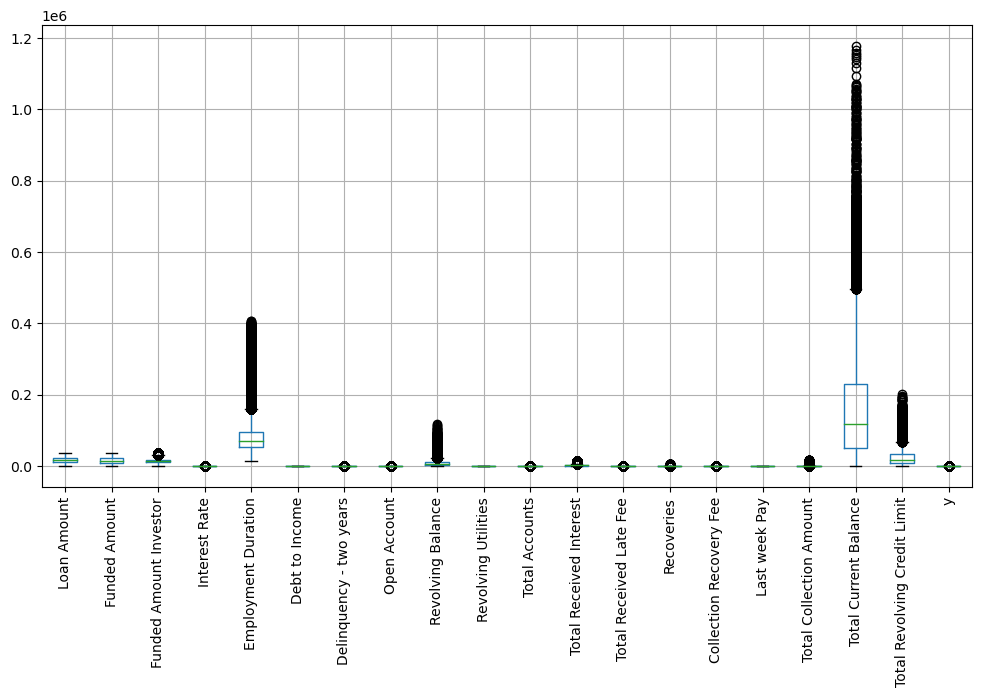

In [20]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 6))
numeric_data.boxplot()
plt.xticks(rotation=90)
plt.show()

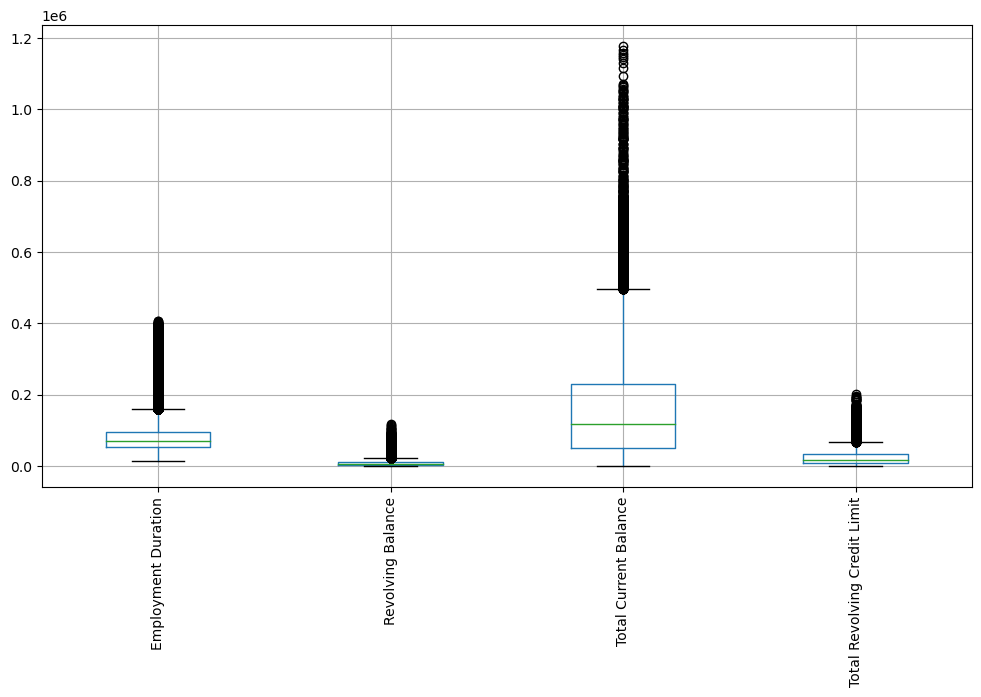

In [21]:
# List of columns to plot
columns_to_plot = ['Employment Duration', 'Revolving Balance', 'Total Current Balance', 'Total Revolving Credit Limit']

plt.figure(figsize=(12, 6))

# Select only specific columns and then plot
data[columns_to_plot].boxplot()
plt.xticks(rotation=90)

plt.show()

### What do the Outliers Describe?

Outliers describe the 0s and 1s proportionally to how dataset is balanced.

In [22]:
def count_outliers_by_target(data, target_column='y'):
    outlier_counts = {}  # Create a dictionary to store the count of outliers for each column

    # Loop through only numeric columns in the DataFrame
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        if column != target_column:  # Skip the target column itself
            # Use the detect_outliers_iqr function to get the outliers
            outliers = detect_outliers_iqr(data, column)
            
            # Break down the outliers by their 'y' values
            outlier_target_counts = outliers[target_column].value_counts()
            
            # Calculate the total outliers for the current column
            total_outliers = len(outliers)
            
            # Compute proportions
            outlier_proportions = (outlier_target_counts / total_outliers).to_dict()
            
            # Store the counts and proportions in the outlier_counts dictionary
            outlier_counts[column] = {
                'counts': outlier_target_counts.to_dict(),
                'proportions': outlier_proportions
            }

    return outlier_counts

# Get the count of outliers for each column based on 'y'
outlier_info_by_y = count_outliers_by_target(data)

# Print the results
for column, info in outlier_info_by_y.items():
    print(f"{column}:")
    for y_value, count in info['counts'].items():
        proportion = info['proportions'][y_value]
        print(f"    y = {y_value}: {count} outliers ({proportion*100:.2f}%)")


Loan Amount:
Funded Amount:
Funded Amount Investor:
    y = 0: 2813 outliers (90.65%)
    y = 1: 290 outliers (9.35%)
Interest Rate:
    y = 0: 749 outliers (88.01%)
    y = 1: 102 outliers (11.99%)
Employment Duration:
    y = 0: 3719 outliers (90.38%)
    y = 1: 396 outliers (9.62%)
Debt to Income:
Delinquency - two years:
    y = 0: 13945 outliers (90.50%)
    y = 1: 1464 outliers (9.50%)
Open Account:
    y = 0: 5109 outliers (91.00%)
    y = 1: 505 outliers (9.00%)
Revolving Balance:
    y = 0: 3375 outliers (90.75%)
    y = 1: 344 outliers (9.25%)
Revolving Utilities:
Total Accounts:
    y = 0: 1284 outliers (90.17%)
    y = 1: 140 outliers (9.83%)
Total Received Interest:
    y = 0: 4509 outliers (90.58%)
    y = 1: 469 outliers (9.42%)
Total Received Late Fee:
    y = 0: 3016 outliers (89.39%)
    y = 1: 358 outliers (10.61%)
Recoveries:
    y = 0: 2092 outliers (90.88%)
    y = 1: 210 outliers (9.12%)
Collection Recovery Fee:
    y = 0: 738 outliers (91.22%)
    y = 1: 71 outl

## Plot Loan Status and Interest Rate

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


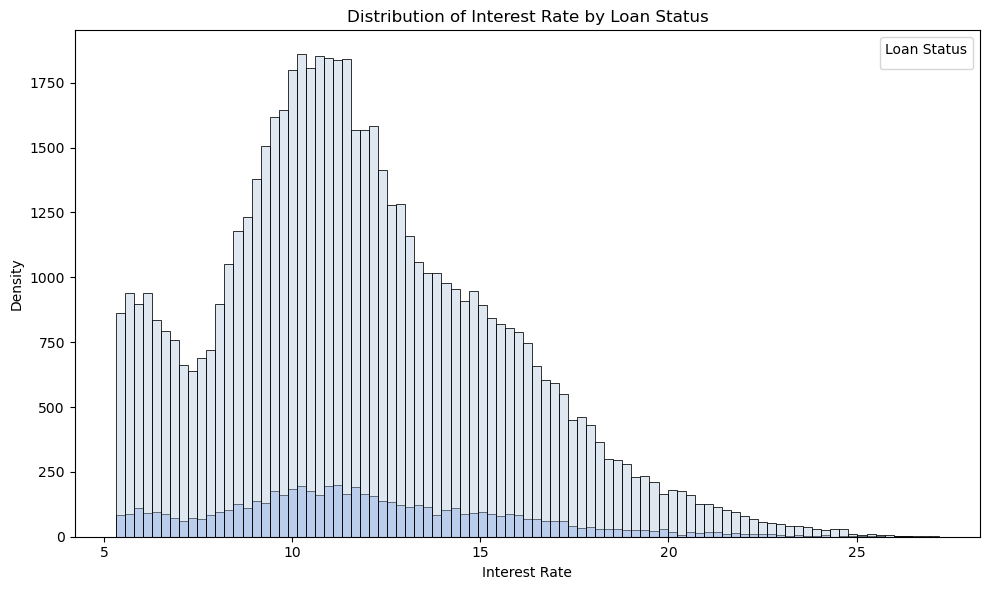

In [23]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting
colors = ['lightsteelblue', 'cornflowerblue']

# Plot the histogram
sns.histplot(data=data, x='Interest Rate',
             hue='y', palette=colors, alpha=0.4)

# Set the title and labels
plt.title('Distribution of Interest Rate by Loan Status')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.legend(title='Loan Status')

# Display the plot
plt.tight_layout()
plt.show()

## Split into Train and Test

In [24]:
# Splitting the data into a training set and a test set
X = data.drop('y', axis=1)
y = data['y']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Categorical Variables to be Encoded

1. Grade: ordinal nature (A-G), use manual mapping.
2. Loan Title: use manual mapping.
3. Home ownership: one-hot encoding.
4. Verification Status: one-hot encoding.
5. Initial List Status: label encoded since it has only two categories.
6. Application Type: label encoded since it has only two categories.
7. Sub Grade: manual mapping as it has many values.

In [25]:
# 1. Grade
grade_mapping = X_train['Grade'].value_counts(normalize=True)
X_train['Grade'] = X_train['Grade'].map(grade_mapping)
X_test['Grade'] = X_test['Grade'].map(grade_mapping)

# 2. Loan Title
loan_title_mapping = X_train['Loan Title'].value_counts(normalize=True)
X_train['Loan Title'] = X_train['Loan Title'].map(loan_title_mapping)
X_test['Loan Title'] = X_test['Loan Title'].map(loan_title_mapping)

# 3. Home ownership
home_ownership_dummies_train = pd.get_dummies(X_train['Home Ownership'], prefix='HomeOwnership', drop_first=True)
X_train = pd.concat([X_train, home_ownership_dummies_train], axis=1)

home_ownership_dummies_test = pd.get_dummies(X_test['Home Ownership'], prefix='HomeOwnership', drop_first=True)
X_test = pd.concat([X_test, home_ownership_dummies_test], axis=1)

X_train.drop('Home Ownership', axis=1, inplace=True)
X_test.drop('Home Ownership', axis=1, inplace=True)

# 4. Verification Status
verification_dummies_train = pd.get_dummies(X_train['Verification Status'], prefix='VerificationStatus', drop_first=True)
X_train = pd.concat([X_train, verification_dummies_train], axis=1)

verification_dummies_test = pd.get_dummies(X_test['Verification Status'], prefix='VerificationStatus', drop_first=True)
X_test = pd.concat([X_test, verification_dummies_test], axis=1)

X_train.drop('Verification Status', axis=1, inplace=True)
X_test.drop('Verification Status', axis=1, inplace=True)

# 5. Initial List Status
# This transformation is independent of the data distribution, so you can safely apply it to both sets
X_train['Initial List Status'] = X_train['Initial List Status'].map({'w': 0, 'f': 1})
X_test['Initial List Status'] = X_test['Initial List Status'].map({'w': 0, 'f': 1})

# 6. Application Type
# This transformation is also independent of the data distribution
X_train['Application Type'] = X_train['Application Type'].map({'JOINT': 0, 'INDIVIDUAL': 1})
X_test['Application Type'] = X_test['Application Type'].map({'JOINT': 0, 'INDIVIDUAL': 1})

# 7. Sub Grade
# This transformation depends on the data distribution in the training set
sub_grade_mapping = X_train['Sub Grade'].value_counts(normalize=True)
X_train['Sub Grade'] = X_train['Sub Grade'].map(sub_grade_mapping)
X_test['Sub Grade'] = X_test['Sub Grade'].map(sub_grade_mapping)

## Data Transformation
Log(x+1) transformation was tested out, standardisation too, but Robust scaler proved to be best. Perform transformations after splitting to prevent leakage.

### Log Transformation

As a lot of distributions are right-skewed, apply Log trasformation to see if the training of models improves.

In [26]:
# Identify numeric columns
#numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Apply log transformation to the training data
#X_train[numeric_cols] = np.log1p(X_train[numeric_cols])

# Apply the same transformation to the test data
#X_test[numeric_cols] = np.log1p(X_test[numeric_cols])

### Standardisation

In [27]:
# Fit the scaler on the training data
#scaler = StandardScaler()
#scaler.fit(X_train)

# Transform the training data
#X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Transform the test data using the same scaler
#X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


### Robust Scaler

In [28]:
# Fit the scaler on the training data
scaler = RobustScaler()
scaler.fit(X_train)

# Transform the training data
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Transform the test data using the same scaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Try Removing Outliers

In [29]:
#def filter_outliers_iqr(data, lower_bound, upper_bound):
#    """Filter out outliers based on predefined bounds."""
#    return data[((data > lower_bound) & (data < upper_bound)).all(axis=1)]

# Get only numeric columns for outlier computation
#numeric_columns = X_train_scaled.select_dtypes(include=['float64', 'int64']).columns

# 1. Compute IQR for the numeric columns in the scaled training data
#Q1_train = X_train_scaled[numeric_columns].quantile(0.25)
#Q3_train = X_train_scaled[numeric_columns].quantile(0.75)
#IQR_train = Q3_train - Q1_train
#lower_bound_train = Q1_train - 1.5 * IQR_train
#upper_bound_train = Q3_train + 1.5 * IQR_train

# 2. Filter Outliers in the Training Data
#filtered_indices_train = filter_outliers_iqr(X_train_scaled[numeric_columns], lower_bound_train, upper_bound_train).index
#X_train_scaled_filtered = X_train_scaled.loc[filtered_indices_train]
#y_train_filtered = y_train[filtered_indices_train]

## Balance Data

SMOTE and ADASYN tested, SMOTE yields better results. It will still be hard to predict 1's.

In [30]:
# Save the algorithm
smote = SMOTE(random_state=42)

# Resample using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled_filtered, y_train_filtered)

# Checking the distribution after SMOTE
print(pd.Series(y_train_resampled).value_counts())

0    48977
1    48977
Name: y, dtype: int64


In [31]:
# Initialize ADASYN
#adasyn = ADASYN(random_state=42)

# Resample using ADASYN
#X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
# Checking the distribution after ADASYN
#print(pd.Series(y_train_resampled).value_counts())


## Model Fitting

Models to be tested: Logistic Regression, Decision Tree, Random Forest, K-Nearest Neighbours classifiers.
Logistic Regression should perform better in cases where there is clear linear relationship. To avoid wasting time, I have continued with the Decision Tree and Random Forest models to try capture more complex, non-linear relationships. As the models with default settings was overfitting the data, I performed some fine-tuning on this model.

In [32]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Initialize lists to store results
train_acc = []
cv_acc = [] 
model_names = []

# Fit the models and get the cross-validation scores
for name, model in models.items():
    
    # Use cross-validation to get average accuracy on the resampled training data
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    cv_acc.append(cv_scores.mean())
    
    # Fit the model on the resampled training data for potential future predictions or evaluation on test data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the resampled training data to get training accuracy
    ypred_train = model.predict(X_train_resampled)
    
    # Calculate accuracy for training data and append to list
    train_acc.append(accuracy_score(y_train_resampled, ypred_train))
    
    # Append model name to list
    model_names.append(name)

# Select the model with the highest cross-validated accuracy and evaluate it further on the test data:
best_index = cv_acc.index(max(cv_acc))
best_model_name = model_names[best_index]
best_model = models[best_model_name]

print(f"Best model based on cross-validation is: {best_model_name}")

Best model based on cross-validation is: Random Forest


### Model Evaluation

In [33]:
print(train_acc)

[0.511740204585826, 1.0, 1.0, 0.8805051350633971]


### Continue with Other Metrics to Evaluate the Performance on Test Data

In [34]:
# Initialize dictionaries to store results
metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC-ROC": [],
    "TP": [],  # True Positives
    "FP": [],  # False Positives
    "TN": [],  # True Negatives
    "FN": []   # False Negatives
}

# Train each model and store their metrics
for name, model in models.items():
    # Predict on test data
    ypred_test = model.predict(X_test_scaled)
    yprob_test = model.predict_proba(X_test_scaled)[:, 1]  
    
    # Extract confusion matrix values
    TN, FP, FN, TP = confusion_matrix(y_test, ypred_test).ravel()
    
    # Store confusion matrix values
    metrics["TP"].append(TP)
    metrics["FP"].append(FP)
    metrics["TN"].append(TN)
    metrics["FN"].append(FN)
    
    # Calculate and store other metrics
    metrics["Accuracy"].append(accuracy_score(y_test, ypred_test))
    metrics["Precision"].append(precision_score(y_test, ypred_test))
    metrics["Recall"].append(recall_score(y_test, ypred_test))
    metrics["F1-Score"].append(f1_score(y_test, ypred_test))
    metrics["AUC-ROC"].append(roc_auc_score(y_test, yprob_test))

# Print the results
for name in model_names:
    index = model_names.index(name)
    print(f"Metrics for {name}:")
    for metric, values in metrics.items():
        print(f"{metric}: {values[index]:.4f}")
    print("-" * 50)

Metrics for Logistic Regression:
Accuracy: 0.5707
Precision: 0.0997
Recall: 0.4535
F1-Score: 0.1635
AUC-ROC: 0.5273
TP: 566.0000
FP: 5110.0000
TN: 7135.0000
FN: 682.0000
--------------------------------------------------
Metrics for Decision Tree:
Accuracy: 0.3861
Precision: 0.0921
Recall: 0.6362
F1-Score: 0.1609
AUC-ROC: 0.4984
TP: 794.0000
FP: 7829.0000
TN: 4416.0000
FN: 454.0000
--------------------------------------------------
Metrics for Random Forest:
Accuracy: 0.9071
Precision: 0.1429
Recall: 0.0008
F1-Score: 0.0016
AUC-ROC: 0.4876
TP: 1.0000
FP: 6.0000
TN: 12239.0000
FN: 1247.0000
--------------------------------------------------
Metrics for K-Nearest Neighbors:
Accuracy: 0.9075
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC-ROC: 0.5000
TP: 0.0000
FP: 0.0000
TN: 12245.0000
FN: 1248.0000
--------------------------------------------------


/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree Fine-Tuning

Training accuracy is much greater than test accuracy with default settings of Decision Tree and Random Forest classifiers - models are overfit. Hyperparameter tuning might be helpful.

In [35]:
import warnings
warnings.filterwarnings('ignore')

# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1, 'sqrt', 'log2']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predict using the best model
ypred_train_best = best_tree.predict(X_train_resampled)
ypred_test_best = best_tree.predict(X_test_scaled)

# Calculate and print the accuracies
train_acc_best = accuracy_score(y_train_resampled, ypred_train_best)
test_acc_best = accuracy_score(y_test, ypred_test_best)

print(f"Training Accuracy (Fine-tuned): {train_acc_best:.4f}")
print(f"Test Accuracy (Fine-tuned): {test_acc_best:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Training Accuracy (Fine-tuned): 0.9365
Test Accuracy (Fine-tuned): 0.6603


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79     12245
           1       0.09      0.29      0.14      1248

    accuracy                           0.66     13493
   macro avg       0.50      0.50      0.46     13493
weighted avg       0.83      0.66      0.73     13493



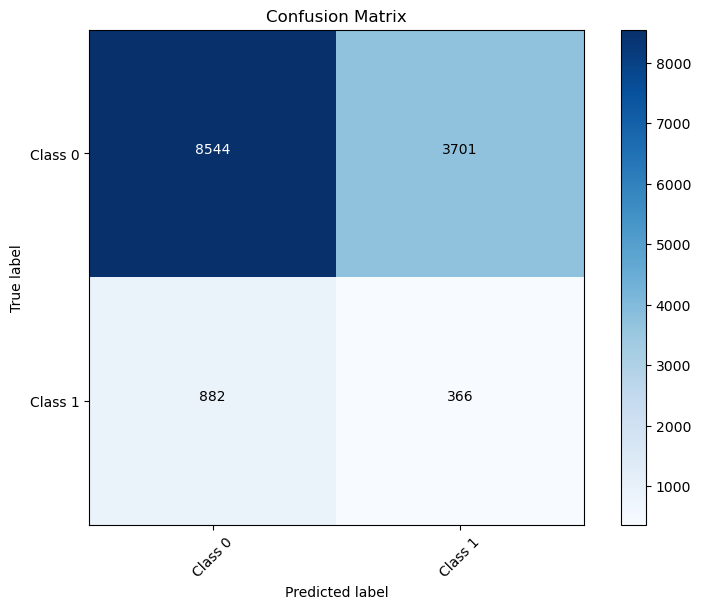

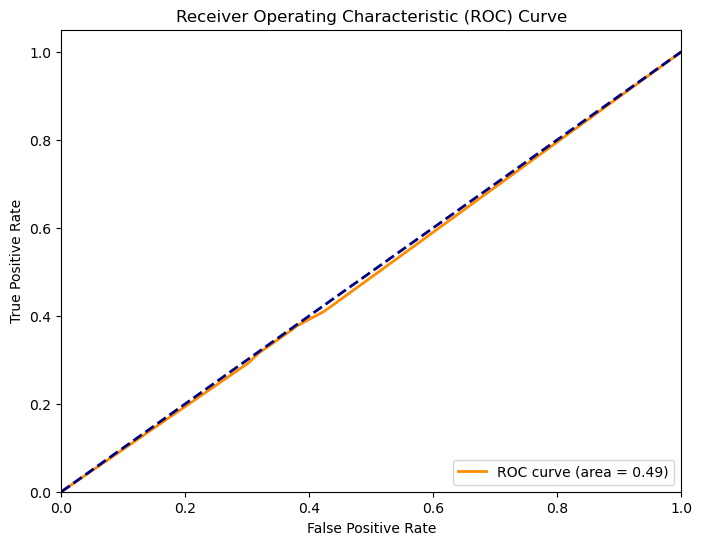

In [36]:
# 1. Print Classification Report
print("Classification Report:")
print(classification_report(y_test, ypred_test_best))

# 2. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, ypred_test_best)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the cells with the absolute values
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()

# 3. Plot ROC-AUC Curve
y_prob_best = best_tree.predict_proba(X_test_scaled)[:, 1]  # probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Extract Feature Importanced from the Decision Tree

 "Grade" probably represents a risk grade assigned to the borrower - it has be greatest importance. 
 The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled. The score function to be used for the computation of importances can be specified with the scoring argument, which also accepts multiple scorers.

In [37]:
# Calculate permutation importances
start_time = time.time()
result = permutation_importance(
    best_tree, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Assuming feature_names is a list of your feature names
feature_names = X_train_resampled.columns.tolist()
dec_tree_importances = pd.Series(result.importances_mean, index=feature_names)

# Sort and print the permutation importances
sorted_importances = dec_tree_importances.sort_values(ascending=False)
print(sorted_importances)

Elapsed time to compute the importances: 10.630 seconds
VerificationStatus_Source Verified    0.014148
VerificationStatus_Verified           0.008708
HomeOwnership_OWN                     0.004402
HomeOwnership_RENT                    0.002075
Recoveries                            0.002038
Collection Recovery Fee               0.000363
Public Record                         0.000289
Total Collection Amount               0.000082
Funded Amount                         0.000000
Total Revolving Credit Limit          0.000000
Total Current Balance                 0.000000
Last week Pay                         0.000000
Application Type                      0.000000
Collection 12 months Medical          0.000000
Total Received Interest               0.000000
Initial List Status                   0.000000
Loan Amount                           0.000000
Revolving Utilities                   0.000000
Revolving Balance                     0.000000
Open Account                          0.000000
Inqu

## Random Forest Fine-Tuning

In [38]:
import warnings
warnings.filterwarnings('ignore')

# Define hyperparameters to tune and their possible values
param_grid = {
    'n_estimators': [100, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best estimator and use it for prediction or further tasks
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.6min
[CV] END ma

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12245
           1       0.12      0.00      0.01      1248

    accuracy                           0.90     13493
   macro avg       0.51      0.50      0.48     13493
weighted avg       0.83      0.90      0.86     13493



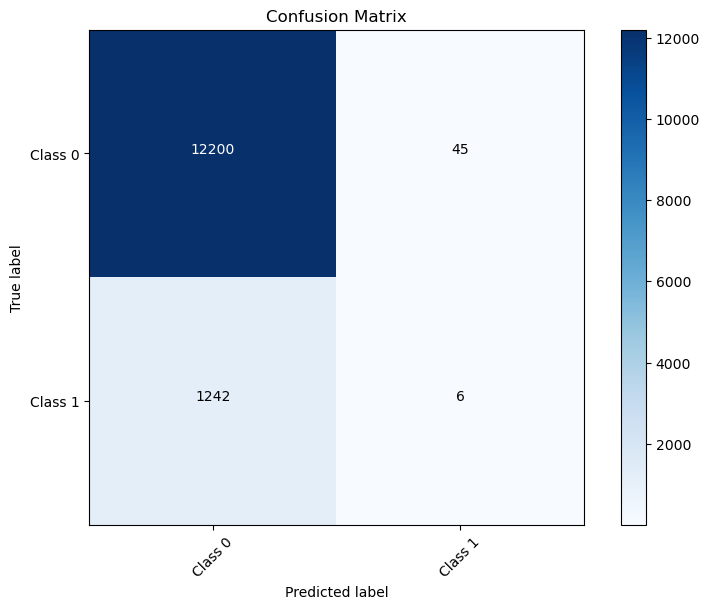

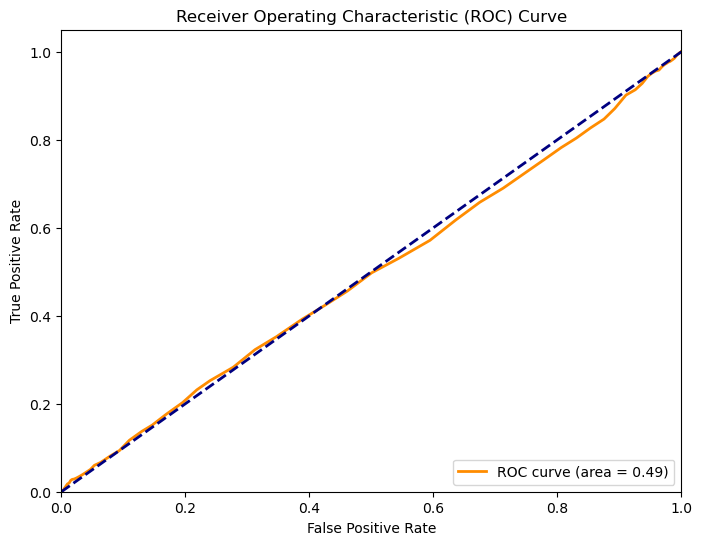

In [39]:
# Predict using the best estimator
ypred_test_best = best_rf.predict(X_test_scaled)

# 1. Print Classification Report
print("Classification Report:")
print(classification_report(y_test, ypred_test_best))

# 2. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, ypred_test_best)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Annotate the cells with the absolute values
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()

# 3. Plot ROC-AUC Curve
y_prob_best = best_rf.predict_proba(X_test_scaled)[:, 1]  # probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Extract Feature Importanced from the Random Forests



In [40]:
# Calculate permutation importances
start_time = time.time()
result = permutation_importance(
    best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Assuming feature_names is a list of your feature names
feature_names = X_train_resampled.columns.tolist()
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Sort and print the permutation importances
sorted_importances = forest_importances.sort_values(ascending=False)
print(sorted_importances)

Elapsed time to compute the importances: 158.532 seconds
VerificationStatus_Source Verified    0.000815
Total Received Late Fee               0.000786
Collection Recovery Fee               0.000711
VerificationStatus_Verified           0.000578
Inquires - six months                 0.000215
Collection 12 months Medical          0.000007
Revolving Balance                     0.000000
Total Revolving Credit Limit          0.000000
Total Current Balance                 0.000000
Application Type                      0.000000
Total Received Interest               0.000000
Funded Amount                         0.000000
Loan Amount                           0.000000
Total Accounts                        0.000000
Employment Duration                   0.000000
Funded Amount Investor                0.000000
Term                                  0.000000
Interest Rate                         0.000000
Debt to Income                        0.000000
Loan Title                            0.000000
Ope

## Results

#### Which metrics to look at?
False Positive (FP): predicting that a person will default, but they actually do not. This could lead to potentially denying a loan to a reliable customer, which could result in a lost business opportunity for the lending institution.
False Negative (FN): predicting that a person will not default, but they actually do. This means you grant a loan to someone who eventually defaults. This scenario is riskier for financial institutions as it leads to financial losses.

Given the financial implications, False Negatives (FN) would be more concerning because lending money to someone who eventually defaults is a direct financial loss. On the other hand, while False Positives could lead to lost opportunities, the financial loss isn't as direct.

Looking at F1 Score might be a good option, as it is the harmonic mean of Precision and Recall.

#### Not Chosen (performs ever so slightly poorer) Decision Tree

The Decision Tree model was fine-tuned and its performance is - very poor. With low weighted accuracy, it could not be trusted for any predictions.
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}

Performance on Test data:
- Considering macro avg (as data is imbalanced):
- precision 0.5
- recall 0.5
- f1-score 0.46

#### The Final Chosen Model: Random Forest

The Random Forest model was fine-tuned and its performance is - very poor. The final Random Forest model best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

Performance on Test data:
- Considering macro avg (as data is imbalanced):
- precision 0.51
- recall 0.5
- f1-score 0.48

#### Conclusions 

1. Perhaps the data is just not great?
2. Wouldn't draw conclusions regarding the feature importance as the model performance was so poor.

The poor model performance could be due to:

1. Missclassifications are happening for the category 1 - "Defaulter", the number of entries for this response in the data was lower than 10% and this imbalance definitely causes issues in classification tasks. This was happening even after addressing the issue of imbalance by using SMOTE algorithm.
2. The features used might not capture all the nuances of a loan applicant's likelihood to default. Important predictors might be missing from the dataset.
3. The Decision Tree algorithm, while interpretable, might not be the most suitable model for this kind of data. More complex models like Random Forests or Gradient Boosted Trees might perform better.
4. The quality of the data might be questionable, there are plenty of outliers, that affect the model's performance.
5. The preprocessing steps, including encoding of categorical variables, or scaling of features, might not be optimal for the algorithms.
6. Bad data in... Variables that catch the relationship with the target are not in the dataset.
7. Any other things I might've missed...

### Limitations 

1. The model might have selection bias if the dataset isn't representative, potentially skewing predictions due to an overrepresentation of high credit score applicants.
2. The model's assumption of predictor independence might be flawed, as variables like income and employment status could be interrelated.
3. The model might not account for temporal or seasonal trends if the data spans across different time periods.
4. The model does not consider external economic factors that could influence an applicant's ability to repay loans, such as economic downturns.


### For Future

1. Visualise the trees to check which predictors are of greatest importance.
2. Pre-select features based on field-knowledge and statistical metrics.
2. Need to check for more complex relationships: interaction terms, polynomial modelling etc - essentially experimenting with feature engineering.
2. Other types of balancing algorithms could be explored, such as: Tomek links, Cluster centroids.
